In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import sympy as sym
import warnings

from IPython.display import display, Math, clear_output
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy import constants
from scipy.constants import c
from scipy.constants import value
from scipy.special import erfc
from scipy.signal import correlate, lfilter
from numpy.random import normal
import os

from optic.core import parameters
from optic.dsp import firFilter, pulseShape,  lowPassFIR,  pnorm
from optic.models import mzm, photodiode
from optic.plot import eyediagram
from optic.modulation import GrayMapping, demodulateGray
from commpy.utilities  import signal_power, upsample

## Functions

In [15]:
def cos(x, f, theta):
    return np.cos(2*np.pi*f*x + theta*np.pi/180)

def DMLResponse(f, fr, yp):
    return np.sqrt(fr**4 / ( (f**2-fr**2)**2 + f**2*yp**2/(2*np.pi**2) ))

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def filterNoDelay(h, x):
    """
    h: impulse response (symmetric)
    x: input signal 
    y: output signal
    """   
    N = h.size
    x = np.pad(x, (0, int(N/2)),'constant')
    y = lfilter(h,1,x)
    
    return y[int(N/2):y.size]

def ifBetween(num, lim1, lim2):
    if(num > lim1 and num < lim2):
        return True
    else:
        return False
    
def lms(y, x, Ntaps, mu):
    """
    Apply the LMS (Least Mean Squares) algorithm for equalization.
    Parameters:
        y (ndarray): The received signal.
        x (ndarray): The reference signal.
        Ntaps (int): The number of filter taps.
        mu (float): The LMS step size.

    Returns:
        tuple: A tuple containing:
            - ndarray: The equalized signal.
            - ndarray: The final equalizer filter coefficients.
    """
    # Initialize the equalizer filter coefficients
    h = np.zeros(Ntaps)
    L = len(h)//2 #decision delay

    # Apply the LMS algorithm
    squaredError = np.zeros(y.shape)
    out = np.zeros(y.shape)
    ind = np.arange(-L,L+1)
    y = np.pad(y,(L,L))

    # Iterate through each sample of the signal
    for i in range(L, len(y)-L):
        y_vec = y[i+ind][-1::-1]

        # Generate the estimated signal using the equalizer filter
        xhat = np.dot(y_vec, h)

        # Compute the error between the estimated signal and the reference signal
        error = x[i-L] - xhat

        # Update the filter coefficients using the LMS update rule
        h = h + mu * y_vec * error

        squaredError[i-L] = error**2
        out[i-L] = xhat

    return out, h, squaredError

In [9]:
VarianceArray = [8.5e9,10.5e9,12.5e9,15e9,17e9,19e9,21e9] # Gauss Bandwidth 3dB of 20GHz, 25GHz, 30GHz, 35GHz, 40GHz, 45GHz, 50GHz
BandArray = [20,25,30,35,40,45,50]

Progress: 28/28


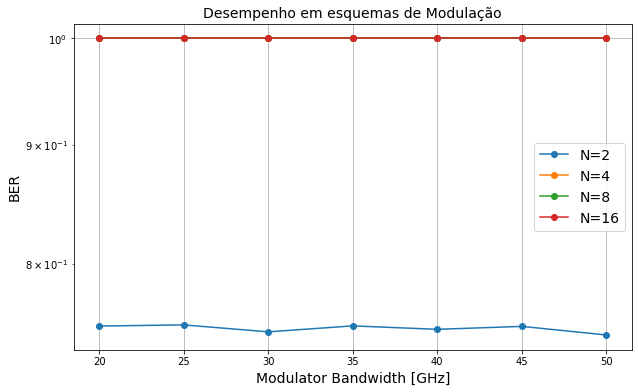

In [22]:
NArray = [2,4,8,16] # N-PAM Array
NumAm = 10000 # Número de amostras
NumPts = 7 # Número de pontos
BERArray = np.zeros((len(NArray),NumPts))

SpS = 16 # Samples per symbol
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

# pulso cosseno levantado (raised cosine)
Ncoeffs = 1024
rolloff1 = 0.1
rolloff2 = 0.1
fftSize = 2**12 # FFT Size

for m in range(len(NArray)):
    for l in range(NumPts):
        
        N = NArray[m]
        choiceArray = np.arange(-N+1,N,2)

        Rs  = 100e9/np.log2(N) # Taxa de símbolos (para o caso do OOK Rs = Rb)

        sTx1 = np.random.choice(choiceArray, NumAm) # Subchannel 1
        sTx2 = np.random.choice(choiceArray, NumAm) # Subchannel 2
        sTx1 = pnorm(sTx1)
        sTx2 = pnorm(sTx2)
        sTx = sTx1 + 1j*sTx2 # Complex representation of subchannels

        # upsampling
        symbolsUp = upsample(sTx, SpS)

        x = np.linspace(0,Ts,Ncoeffs)

        senoid1 = cos(x,16*Rs,0)
        senoid2 = cos(x,16*Rs,-90)

        pulse1 = pulseShape('rrc', SpS, Ncoeffs, rolloff1, Ts)
        pulse1RRC = pulse1/np.max(np.abs(pulse1))
        pulse1 = (pulse1*senoid1)/np.max(np.abs(pulse1*senoid1))
        pulse2 = pulseShape('rrc', SpS, Ncoeffs, rolloff2, Ts)
        pulse2RRC = pulse2/np.max(np.abs(pulse2))
        pulse2 = (pulse2*senoid2)/np.max(np.abs(pulse2*senoid2))

        # formatação de pulso 
        sigTx1 = firFilter(pulse1, symbolsUp.real)
        sigTx2 = firFilter(pulse2, symbolsUp.imag)

        DCbias = -1*min(sigTx1+sigTx2)
        sigTxAll = sigTx1+sigTx2 + DCbias*np.ones(len(sigTx1))

        freqArray = np.fft.fftfreq(10000, d=1/200e9)

        DMLGauss = gaussian(freqArray, 0e9, VarianceArray[l])*0.008 

        CutRange = 1000*SpS

        DMLGaussTime = np.fft.ifft(DMLGauss)
        sigTxDml = np.convolve(DMLGaussTime,sigTxAll,mode='same')
        sigTxDml = sigTxDml[CutRange:-CutRange]

        sigTxo = np.abs(sigTxDml)

        # ideal photodiode (noiseless, no bandwidth limitation)
        paramPD = parameters()
        paramPD.ideal = True
        I_Rx_ideal = photodiode(sigTxo.real, paramPD)

        # noisy photodiode (thermal noise + shot noise + bandwidth limitation)
        paramPD = parameters()
        paramPD.ideal = False
        paramPD.B = Rs
        paramPD.Fs = Fa

        I_Rx = photodiode(sigTxo, paramPD)

        sigTxo = I_Rx/max(I_Rx)

        conv1 = firFilter(pulse1[-1::-1],sigTxo)
        conv2 = firFilter(pulse2[-1::-1],sigTxo)

        Tx1ADC = conv1[::SpS]
        Tx2ADC = conv2[::SpS]

        Tx1ADC = Tx1ADC - Tx1ADC.mean()
        Tx1ADC = pnorm(Tx1ADC)
        Tx1ADC = Tx1ADC*((1+max(sTx.real))/max(Tx1ADC))
        Tx2ADC = Tx2ADC - Tx2ADC.mean()
        Tx2ADC = pnorm(Tx2ADC)
        Tx2ADC = Tx2ADC*((1+max(sTx.imag))/max(Tx2ADC))

        Ntaps = 15
        EqStep = 0.001

        Tx1Am, h_eq, squaredError = lms(Tx1ADC, sTx.real, Ntaps, EqStep)
        Tx1Am = scipy.signal.fftconvolve(Tx1Am,h_eq,'same')
        Tx2Am, h_eq, squaredError = lms(Tx2ADC, sTx.imag, Ntaps, EqStep)
        Tx2Am = scipy.signal.fftconvolve(Tx2Am,h_eq,'same')

        const = GrayMapping(N,'pam') # get PAM constellation
        Es = signal_power(const) # calculate the average energy per symbol of the PAM constellation
        bitsRx1 = demodulateGray(Tx1ADC, N, 'pam')
        bitsRx2 = demodulateGray(Tx2ADC, N, 'pam')

        sTx1cut = sTx1[int(CutRange/SpS):int(-CutRange/SpS)]
        sTx2cut = sTx2[int(CutRange/SpS):int(-CutRange/SpS)]


        # obtém estatísticas do sinal recebido
        IdArray1 = np.zeros(N-1)
        IdArray2 = np.zeros(N-1)
        for i in range(N-1):
            IdArray1[i] = np.average([choiceArray[i+1],choiceArray[i]]) + Tx1ADC.mean()
            IdArray2[i] = np.average([choiceArray[i+1],choiceArray[i]]) + Tx2ADC.mean()
        #print(f'IdArray: {IdArray}')

        IdArray1 = np.pad(IdArray1,(1,1),'constant', constant_values=(-10*N, 10*N))
        check = 0
        for i in range(IdArray1.size - 1):
            for j in range(sTx1cut.size):
                if(ifBetween(bitsRx1[j], IdArray1[i], IdArray1[i+1]) and sTx1cut[j]==choiceArray[i]):
                    check = check + 1
        for i in range(IdArray2.size - 1):
            for j in range(sTx2cut.size):
                if(ifBetween(bitsRx2[j], IdArray2[i], IdArray2[i+1]) and sTx2cut[j]==choiceArray[i]):
                    check = check + 1

        BER = ((sTx1cut.size + sTx2cut.size)-check)/(sTx1cut.size + sTx2cut.size)

        # print(f'Total de erros contados = {sTx1.size-check}')
        # print('BER = %.2e  '%(BER))

        BERArray[m,l] = BER
        clear_output(wait=True)
        print(f'Progress: {(m*NumPts)+(l+1)}/{NumPts*len(NArray)}')

plt.figure(figsize=(10,6))
for i in range(len(NArray)):
    plt.semilogy(BandArray,BERArray[i], '-o',  label=f'N={NArray[i]}')
plt.title('Desempenho em esquemas de Modulação',fontsize=14)
plt.xlabel('Modulator Bandwidth [GHz]',fontsize=14)
plt.ylabel('BER',fontsize=14)
plt.legend(fontsize=14)
plt.grid()

datapath = 'Media'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig("Media/BERxModBand" + str(file_count) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

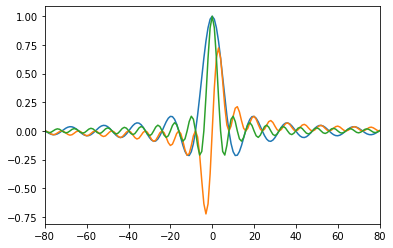

<Figure size 432x288 with 0 Axes>

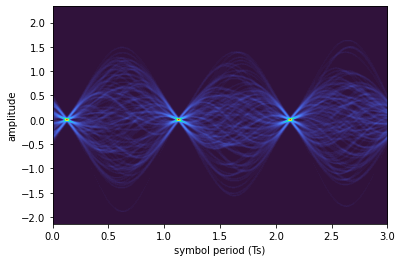

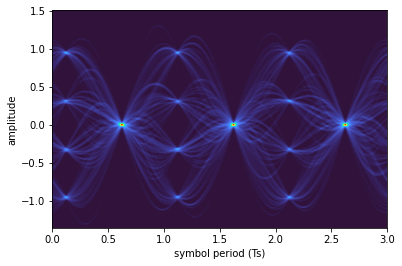

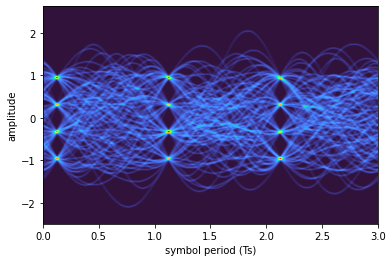

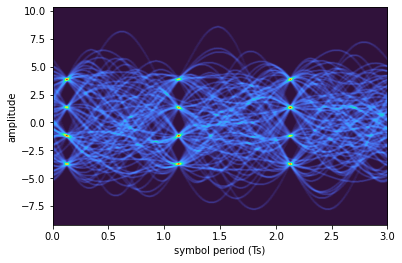

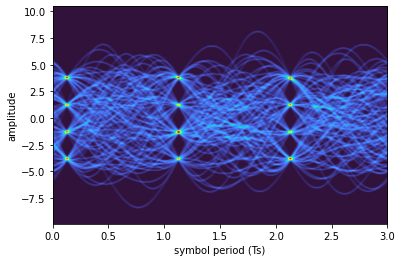

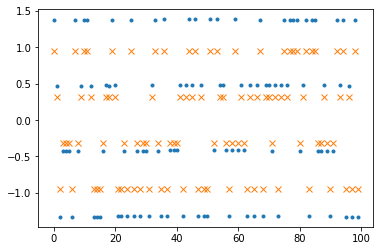

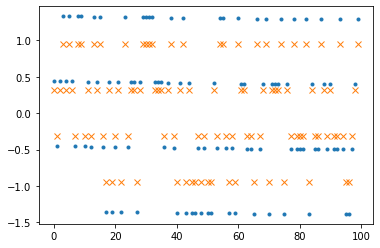

In [21]:
import numpy as np
from commpy.utilities  import upsample
from optic.modulation import GrayMapping, modulateGray
from optic.dsp import firFilter, pulseShape, pnorm
from optic.plot import eyediagram
import matplotlib.pyplot as plt

M = 16
SpS = 8

# RRC pulse
pulse = pulseShape('rrc', SpS, N=2048, alpha=0.01)
pulse = pulse/max(abs(pulse))

fc = 1/(2*SpS)

n = np.arange(-len(pulse)/2, len(pulse)/2)

g1 = pulse*np.sin(2*np.pi*fc*n)
g2 = pulse*np.cos(2*np.pi*fc*n)

plt.plot(n, pulse)
plt.plot(n, g1)
plt.plot(n, g2)
plt.xlim(-80,80)
plt.figure()

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=200000)

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulse shaping
sigTx1 = firFilter(g1, symbolsUp.real)
sigTx2 = firFilter(g2, symbolsUp.imag)

sigTx = sigTx1 + sigTx2

eyediagram(sigTx1,len(sigTx1),SpS, ptype='fancy')
eyediagram(sigTx2,len(sigTx2),SpS, ptype='fancy')
eyediagram(sigTx,len(sigTx2),SpS, ptype='fancy')

# matched filter
sigRx1 = firFilter(g1[-1::-1], sigTx).real
sigRx2 = firFilter(g2[-1::-1], sigTx).real

eyediagram(sigRx1,len(sigRx1),SpS, ptype='fancy')
eyediagram(sigRx2,len(sigRx2),SpS, ptype='fancy')

pamRx1 = pnorm(sigRx1[1::SpS])
pamRx2 = pnorm(sigRx2[1::SpS])

ind = np.arange(200,300)
plt.figure()
plt.plot(pamRx1[ind],'.')
plt.plot(symbTx[ind].real,'x')

plt.figure()
plt.plot(pamRx2[ind],'.')
plt.plot(symbTx[ind].imag,'x')